# Evaluation

In [2]:
import csv
import json
import subprocess
import os
import timeit
import polars as pl

In [3]:
with open('../2-pattern-extraction/pattern_occurrences.csv', 'r') as f:
    reader = csv.DictReader(f)
    occurrences = {}
    for row in reader:
        if row['pattern'] not in occurrences:
            occurrences[row['pattern']] = []
        occurrences[row['pattern']].append(row['url'])

with open('../1-coding/diffs.json', 'r') as f:
    diffs = json.load(f)
    filenames = {
        d['url']: [
            f['filename'] for f in d['files']
        ]
        for d in diffs
    }

## Checkov

In [21]:
CHECKOV_CHECKS = {
    'Object storage lifecycle rules': ','.join({
        'CKV2_AWS_61'
    }),
    'AWS - Expensive DynamoDB': ','.join({
        'CKV_AWS_801', # pay per request
        'CKV_AWS_802', # read/write capacity
        'CKV_AWS_803', # global secondary indices
    }),
    'Old generation': ','.join({
        'CKV_AWS_804'
    }),
}

checkov_stats = []

for pattern, checks in CHECKOV_CHECKS.items():
    print('Analyzing', pattern)

    for url in occurrences[pattern]:
        print('-', url)

        _, _, _, owner, name, _, sha = url.split('/')

        snapshot_path = f'snapshots/{owner}-{name}-{sha}'

        summary = {
            'pattern': pattern,
            'url': url,
            'before': [],
        }

        # Versions are "after" (state after the commit) and one or more "before_<sha>" (one or more parent commits)
        for version in os.listdir(snapshot_path):
            version_path = f'{snapshot_path}/{version}/'

            print(f'    * Running checkov against `{version}`')

            start = timeit.default_timer()

            result = subprocess.run([
                'checkov',
                '--evaluate-variables', 'true',
                '--download-external-modules', 'true',
                '--external-modules-download-path', '/tmp/',
                '--directory', version_path,
                '--check', checks,
                '-o', 'json',
                '--framework', 'terraform',
            ], capture_output=True, encoding='utf-8')

            end = timeit.default_timer()

            if version == 'after':
                summary['after'] = {
                    'return_code': result.returncode,
                    'stdout': result.stdout,
                    'stderr': result.stderr,
                    'duration_seconds': end - start,
                }
            else:
                summary['before'].append({
                    'return_code': result.returncode,
                    'stdout': result.stdout,
                    'stderr': result.stderr,
                    'duration_seconds': end - start,
                })

            print(f'      Done after {end - start:.2f}s')

        checkov_stats.append(summary)

Analyzing Object storage lifecycle rules
- https://github.com/alphagov/govuk-aws/commit/f844cd8e254b161bebef04101f8ce177bcd0840c
    * Running checkov against `after`
      Done after 37.52s
    * Running checkov against `before-f9fc11443ab8926b0761fb890974cd7169f9235f`
      Done after 39.38s
- https://github.com/alphagov/govuk-terraform-provisioning/commit/ac105ab0a5ae38fbf69167e072f8970a4a61c3e8
    * Running checkov against `after`
      Done after 6.69s
    * Running checkov against `before-c167e29c9d5867b897bd035315341d14fff84f29`
      Done after 4.45s
- https://github.com/ExpediaGroup/apiary-data-lake/commit/47e62f2fc73a96611606cd619c084d1ded9d844d
    * Running checkov against `after`
      Done after 5.11s
    * Running checkov against `before-f3c3068c66185f51ba97ed71a14ffdbea2a698b1`
      Done after 4.83s
- https://github.com/SamTowne/BasketballDrillBot/commit/4ec6d54e4d36ab02b0a7daf042e727717371eaec
    * Running checkov against `after`
      Done after 4.42s
    * Running

In [22]:
checkov_df = pl.DataFrame(checkov_stats)

with pl.Config(tbl_rows=150, tbl_width_chars=500):
    print(checkov_df)

checkov_df.write_json('results_checkov.json', row_oriented=True)

shape: (65, 4)
┌────────────────────────────────┬─────────────────────────────────┬──────────────────────────┬───────────────────────────┐
│ pattern                        ┆ url                             ┆ before                   ┆ after                     │
│ ---                            ┆ ---                             ┆ ---                      ┆ ---                       │
│ str                            ┆ str                             ┆ list[struct[4]]          ┆ struct[4]                 │
╞════════════════════════════════╪═════════════════════════════════╪══════════════════════════╪═══════════════════════════╡
│ Object storage lifecycle rules ┆ https://github.com/alphagov/go… ┆ [{1,"{                   ┆ {1,"{                     │
│                                ┆                                 ┆     "check_type": "terr… ┆     "check_type": "terra… │
│ Object storage lifecycle rules ┆ https://github.com/alphagov/go… ┆ [{1,"{                   ┆ {1,"{                

## Tflint

In [4]:
TFLINT_RULES = {
    'Budget': '--only=cost_aws_budget',
    'Object storage lifecycle rules': '--only=cost_aws_object_storage_lifecycle_rule',
    'Old generation': '--only=cost_aws_old_generation',
    'AWS - Expensive DynamoDB': '--only=cost_aws_expensive_dynamodb'
}

tflint_stats = []

for pattern, rules in TFLINT_RULES.items():
    print('Analyzing', pattern)

    for url in occurrences[pattern]:
        print('- ', url)

        _, _, _, owner, name, _, sha = url.split('/')

        snapshot_path = f'snapshots/{owner}-{name}-{sha}'

        summary = {
            'pattern': pattern,
            'url': url,
            'before': [],
        }

        for version in os.listdir(snapshot_path):
            version_path = f'{snapshot_path}/{version}/'

            print(f'    * Running tflint against `{version}`')

            print('      terraform get')

            terraform_result = subprocess.run(['terraform', f'-chdir={version_path}', 'get'], capture_output=True, encoding='utf-8')

            print(f'      terraform get returned with status {terraform_result.returncode}')

            print('      Starting tflint')

            start = timeit.default_timer()

            result = subprocess.run([
                'tflint',
                '--format=json',
                '--call-module-type=all',
                '--enable-plugin=cost',
                rules,
                f'--chdir={version_path}'
            ], capture_output=True, encoding='utf-8')

            end = timeit.default_timer()

            if version == 'after':
                summary['after'] = {
                    'return_code': result.returncode,
                    'stdout': result.stdout,
                    'stderr': result.stderr,
                    'duration_seconds': end - start,
                }
            else:
                summary['before'].append({
                    'return_code': result.returncode,
                    'stdout': result.stdout,
                    'stderr': result.stderr,
                    'duration_seconds': end - start,
                })

            print(f'      Done after {end - start:.2f}s')

        tflint_stats.append(summary)

Analyzing Budget
-  https://github.com/AJarombek/global-aws-infrastructure/commit/4a89f4b8235961275fa0e6aaf20848f2b8b7e733
    * Running tflint against `after`
      terraform get
      terraform get returned with status 0
      Starting tflint
      Done after 0.06s
    * Running tflint against `before-d79ab7eb96ba8d1bd6600ad116d024c124967e3a`
      terraform get
      terraform get returned with status 0
      Starting tflint
      Done after 0.06s
-  https://github.com/MartinFeineis/terraform/commit/359ba426393c78b78695797f9bdd6a08c0455720
    * Running tflint against `after`
      terraform get
      terraform get returned with status 0
      Starting tflint
      Done after 0.14s
    * Running tflint against `before-a78936b97d7c08b1f82e01361ba27def21aa8f00`
      terraform get
      terraform get returned with status 0
      Starting tflint
      Done after 0.14s
-  https://github.com/stuartellis/stuartellis-org-tf-modules/commit/39a9cabac6765c75591ba258fef0d10ba7ae0f9e
    * Runn

In [23]:
tflint_df = pl.DataFrame(tflint_stats)

with pl.Config(tbl_rows=150, tbl_width_chars=500):
    print(tflint_df)

tflint_df.write_json('results_tflint.json', row_oriented=True)

shape: (92, 4)
┌────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ pattern                        ┆ url                             ┆ before                          ┆ after                           │
│ ---                            ┆ ---                             ┆ ---                             ┆ ---                             │
│ str                            ┆ str                             ┆ list[struct[4]]                 ┆ struct[4]                       │
╞════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╡
│ Budget                         ┆ https://github.com/AJarombek/g… ┆ [{0,"{"issues":[],"errors":[]}… ┆ {0,"{"issues":[],"errors":[]}"… │
│ Budget                         ┆ https://github.com/MartinFeine… ┆ [{2,"{"issues":[{"rule":{"name… ┆ {2,"{"issues":[{"rule":{"name"… │
│ Budget                  

## Precision/recall

In [24]:
checkov_clean = checkov_df.filter(pl.col('before').list.len() != 0)

checkov_pr = checkov_clean.select(
    'pattern',
    tp=pl.col('before').list.get(0).struct.field('return_code') == 1,
    fn=pl.col('before').list.get(0).struct.field('return_code') != 1,
    tn=pl.col('after').struct.field('return_code') == 0,
    fp=pl.col('after').struct.field('return_code') != 0,
) \
.group_by('pattern').sum() \
.select(
    'pattern',
    precision=pl.col('tp') / (pl.col('tp') + pl.col('fp')),
    recall=pl.col('tp') / (pl.col('tp') + pl.col('fn')),
)

print(checkov_pr)

checkov_pr.write_csv('pr_checkov.csv')

shape: (3, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ AWS - Expensive DynamoDB       ┆ 0.714286  ┆ 1.0      │
│ Object storage lifecycle rules ┆ 0.75      ┆ 1.0      │
│ Old generation                 ┆ 0.606061  ┆ 0.606061 │
└────────────────────────────────┴───────────┴──────────┘


In [6]:
tflint_clean = tflint_df \
    .filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('return_code') != 1,
        pl.col('after').struct.field('return_code') != 1,
    ])

tflint_pr = tflint_clean.select(
    'pattern',
    tp=pl.col('before').list.get(0).struct.field('return_code') == 2,
    fn=pl.col('before').list.get(0).struct.field('return_code') != 2,
    tn=pl.col('after').struct.field('return_code') == 0,
    fp=pl.col('after').struct.field('return_code') != 0,
) \
.group_by('pattern').sum() \
.select(
    'pattern',
    precision=pl.col('tp') / (pl.col('tp') + pl.col('fp')),
    recall=pl.col('tp') / (pl.col('tp') + pl.col('fn')),
)

print(tflint_pr)

tflint_pr.write_csv('pr_tflint.csv')

shape: (4, 3)
┌────────────────────────────────┬───────────┬──────────┐
│ pattern                        ┆ precision ┆ recall   │
│ ---                            ┆ ---       ┆ ---      │
│ str                            ┆ f64       ┆ f64      │
╞════════════════════════════════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 1.0       ┆ 0.2      │
│ AWS - Expensive DynamoDB       ┆ 0.875     ┆ 0.318182 │
│ Budget                         ┆ 0.5       ┆ 0.166667 │
│ Old generation                 ┆ 0.5       ┆ 0.035714 │
└────────────────────────────────┴───────────┴──────────┘


## Timing

[4.538390829024138, 9.031978889936]


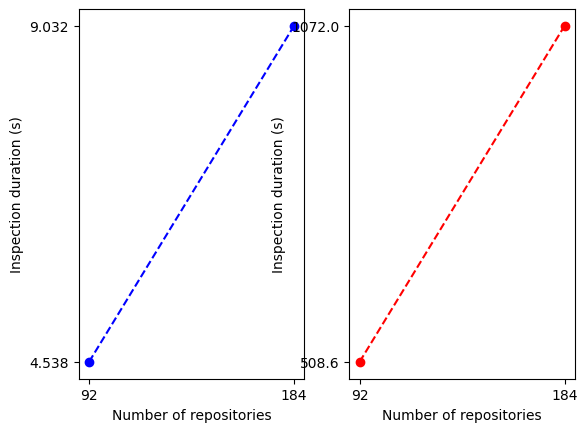

In [29]:
import matplotlib.pyplot as plt

tflint_timing_count = [
    len(tflint_df),
    2 * len(tflint_df),
]
tflint_timing_duration = [
    tflint_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration_seconds')
    ).sum().item(),
    tflint_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration_seconds') + pl.col('after').struct.field('duration_seconds')
    ).sum().item()
]

checkov_timing_count = list(tflint_timing_count)
checkov_timing_duration = [
    checkov_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration_seconds')
    ).sum().item(),
    checkov_df.select(
        duration=pl.col('before').list.get(0).struct.field('duration_seconds') + pl.col('after').struct.field('duration_seconds')
    ).sum().item(),
]

print(tflint_timing_duration)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.set_xlabel('Number of repositories')
ax1.set_ylabel('Inspection duration (s)')
ax1.set_xticks(tflint_timing_count)
ax1.set_yticks(tflint_timing_duration)

ax1.plot(tflint_timing_count, tflint_timing_duration, 'bo--')

ax2.set_xlabel('Number of repositories')
ax2.set_ylabel('Inspection duration (s)')
ax2.set_xticks(checkov_timing_count)
ax2.set_yticks(checkov_timing_duration)

ax2.plot(checkov_timing_count, checkov_timing_duration, 'ro--')